# Federated Learning with BloodMNIST2D Dataset
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/fl-tutorial/blob/gh-pages/tutorial_notebooks/Tutorial_1_Medmnist_2D.ipynb)
### Note: If running the notebook on google colab, please make sure to use python version 3.8, OpenFL works with this version only.


### Dependencies and Packages
Let's get these out of the way first.

In [1]:
!python -m pip install -U pip
!python -m pip install tqdm torch torchvision medmnist matplotlib
!pip install ipywidgets

In [2]:
# To access example workspaces and director/envoy scripts
!rm -rf openfl
!git clone -b miccai_fl_tutorial https://github.com/intel/openfl.git
!cd openfl && python -m pip install .

Cloning into 'openfl'...
remote: Enumerating objects: 5025, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 5025 (delta 204), reused 272 (delta 90), pack-reused 4591
Receiving objects: 100% (5025/5025), 118.37 MiB | 2.50 MiB/s, done.
Resolving deltas: 100% (2887/2887), done.
Processing /home/karan/workspace/fl-tutorial/tutorial_notebooks/openfl
  Preparing metadata (setup.py) ... done
  Created wheel for openfl: filename=openfl-1.4-py3-none-any.whl size=615343 sha256=2061f779b2e2211f6ce1f801a8c2180f6a4105e4935bd15bacc871beb582417e
  Stored in directory: /tmp/pip-ephem-wheel-cache-i8_nxqx7/wheels/63/88/54/cd14f60121c308a944503cb09825c66d9f4c92e44e441e9a80
Successfully built openfl
  Attempting uninstall: openfl
    Found existing installation: openfl 1.4
    Uninstalling openfl-1.4:
      Successfully uninstalled openfl-1.4


### Hacks

A few duct-tape fixes to allow us to 1-click execute.

In [3]:
import os
import logging

# Better CPU Utilization
os.environ['OMP_NUM_THREADS'] = str(int(os.cpu_count()))

# Logging fix for Google Colab
log = logging.getLogger()
log.setLevel(logging.INFO)

# Switch to the tutorial directory within OpenFL tutorials
tutorial_dir = os.path.abspath(
    'openfl/openfl-tutorials/interactive_api/PyTorch_MedMNIST_2D')
os.chdir(tutorial_dir)

# Part 1. Centralized Setting

Setting up your model, optimizer and data.

### Imports

In [4]:
import numpy as np
from tqdm import tqdm
from pprint import pprint

import torch
import medmnist

print('PyTorch', torch.__version__)
print('MedMNIST', medmnist.__version__)

PyTorch 1.8.2+cu111
MedMNIST 2.2.1


### Familiarize yourself with the Dataset

MedMNIST is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. MedMNIST is designed to perform classification on lightweight 2D and 3D images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label).

![Datasets in MedMNIST](https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/assets/medmnistv2.jpg)

Source: https://github.com/MedMNIST/MedMNIST

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint arXiv:2110.14795, 2021.

### Dataset Configuration

In [5]:
# Train/test options
NUM_EPOCHS = 3
BATCH_SIZE = 64
DEVICE = 'cpu'

# Dataset
DATASET_NAME = 'bloodmnist'
DATASET_PATH = './data'
ds_info = medmnist.INFO[DATASET_NAME]
pprint(ds_info)

{'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'description': 'The BloodMNIST is based on a dataset of individual normal '
                'cells, captured from individuals without infection, '
                'hematologic or oncologic disease and free of any '
                'pharmacologic treatment at the moment of blood collection. It '
                'contains a total of 17,092 images and is organized into 8 '
                'classes. We split the source dataset with a ratio of 7:1:2 '
                'into training, validation and test set. The source images '
                'with resolution 3Ã—360Ã—363 pixels are center-cropped into '
                '3Ã—200Ã—200, and then resized into 3Ã—28Ã—28.',
 'label': {'0': 'basophil',
           '1': 'eosinophil',
           '2': 'erythroblast',
           '3': 'immature granulocytes(myelocytes, metamyelocytes and '
                'promyelocytes)',
           '4': 'lymphocyte',
           '5': 'monocyte',
           '6': 'neutrophil',


### Familiarize with the Dataset

Let's use some plotting tools here.

  0%|          | 0/35461855 [00:00<?, ?it/s]

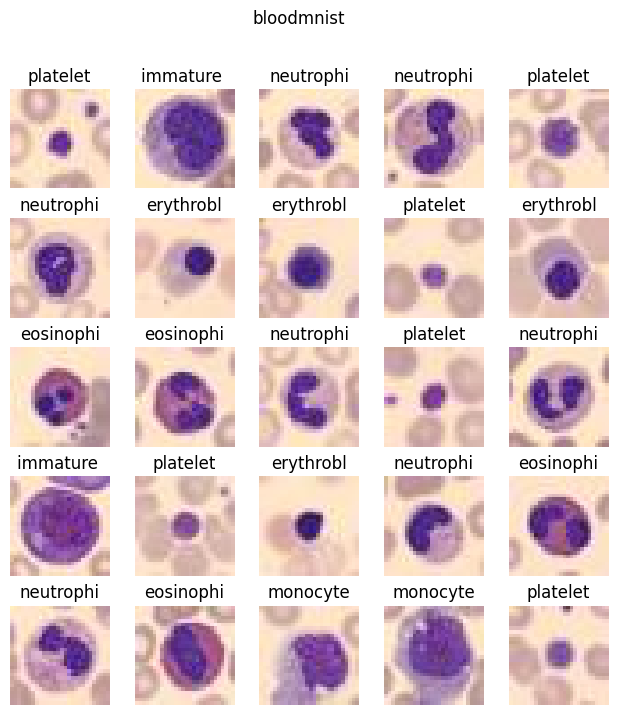

In [6]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

from envoy.medmnist_shard_descriptor import MedMNISTShardDescriptor

# Download raw numpy dataset
sd = MedMNISTShardDescriptor(datapath=DATASET_PATH, dataname=DATASET_NAME)
(x_train, y_train), (x_test, y_test) = sd.load_data()

# Visualize few samples
n_img = 5
train_samples = x_train[:n_img*n_img]

label2str = list(ds_info['label'].values())

fig, ax = plt.subplots(n_img, n_img, figsize=(8, 8))

for k in range(len(train_samples)):
    i = k // n_img
    j = k % n_img
    img = train_samples[k]
    label = np.squeeze(y_train[k])
    ax[i, j].imshow(Image.fromarray(img))
    ax[i, j].title.set_text(label2str[label][:9])
    ax[i, j].axis('off')
plt.suptitle(DATASET_NAME)
fig.subplots_adjust(wspace=0.03, hspace=0.3)


### Define Dataset/Dataloader Classes

We'll create a simple PyTorch-style iterator dataset that returns single `numpy` element as a `torch.Tensor`. The class used for this would be `torch.utils.data.Dataset`

We will then wrap this dataset object with a Dataloader class, that batches and shuffles the elements. Class: `torch.utils.data.DataLoader`

In [7]:

class MedMNISTDataset(Dataset):
    """MedMNIST dataset class"""

    def __init__(self, x, y, data_type: str = 'train') -> None:
        """Initialize MedMNISTDataset."""
        self.x, self.y = x, y
        self.data_type = data_type

    def __getitem__(self, index: int):
        """Return an item by the index."""
        return self.x[index], self.y[index]

    def __len__(self) -> int:
        """Return the len of the dataset."""
        return len(self.x)


class TransformDataset(Dataset):
    """Apply transforms to each element of dataset"""

    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]

        if self.target_transform:
            label = self.target_transform(label)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        
        return img, label


transform = T.Compose([T.ToTensor(), T.Normalize(mean=[0.], std=[1.0])])

train_ds = TransformDataset(MedMNISTDataset(x=x_train, y=y_train),
                              transform=transform)
train_dl = DataLoader(train_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=8)

test_ds = TransformDataset(MedMNISTDataset(x=x_test, y=y_test),
                             transform=transform)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=8)


### Model Definition (CNN)

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, 16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(16, 16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(16, 64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 128), 
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


test_model = Net(in_channels=ds_info['n_channels'],
                 num_classes=len(ds_info['label']))
print(test_model)
print('Total Parameters:',
      sum([torch.numel(p) for p in test_model.parameters()]))
print('Trainable Parameters:',
      sum([torch.numel(p) for p in test_model.parameters() if p.requires_grad]))


Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

### Define Training/Validation Loops

In [9]:
def train(model, train_loader, optimizer, device, criterion, task):
    model.train()
    model = model.to(device)

    losses = []
    correct = 0
    total = 0
    for inputs, targets in tqdm(train_loader, desc="train"):

        optimizer.zero_grad()
        outputs = model(inputs.to(device))

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
        else:
            targets = torch.squeeze(targets, 1).long().to(device)
            loss = criterion(outputs, targets)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    total += targets.shape[0]
    correct += torch.sum(outputs.max(1)[1] == targets).item()

    return {
        'train_acc': np.round(correct / total, 3),
        'train_loss': np.round(np.mean(losses), 3),
    }


def validate(model, val_loader, device, criterion, task):
    model.eval()
    model = model.to(device)

    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="validate"):
            outputs = model(inputs.to(device))

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                m = nn.Sigmoid()
                outputs = m(outputs).to(device)
            else:
                targets = torch.squeeze(targets, 1).long().to(device)
                loss = criterion(outputs, targets)

            losses.append(loss.item())
            total += targets.shape[0]
            correct += (outputs.max(1)[1] == targets).sum().cpu().numpy()

        return {
            'val_acc': np.round(correct / total, 3),
            'val_loss': np.round(np.mean(losses), 3),
        }


### Train

This is how you'd train **with** access to all data.

In [10]:
centralized_model = Net(in_channels=ds_info['n_channels'],
                        num_classes=len(ds_info['label']))
optimizer = torch.optim.Adam(centralized_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Start!
history = validate(centralized_model,
                   test_dl,
                   device=DEVICE,
                   criterion=criterion,
                   task=ds_info['task'])
print('Before training: ', history)

for epoch in range(NUM_EPOCHS):
    train_history = train(centralized_model,
                          train_dl,
                          device=DEVICE,
                          optimizer=optimizer,
                          criterion=criterion,
                          task=ds_info['task'])
    val_history = validate(centralized_model,
                           test_dl,
                           device=DEVICE,
                           criterion=criterion,
                           task=ds_info['task'])
    print(f'Epoch {epoch}: {train_history} - {val_history}')


validate: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 54/54 [00:00<00:00, 121.60it/s]


Before training:  {'val_acc': 0.182, 'val_loss': 2.082}


train:   0%|                                                                                                                                                                       | 0/187 [00:00<?, ?it/s]/home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(
validate: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–

Epoch 0: {'train_acc': 0.873, 'train_loss': 1.019} - {'val_acc': 0.821, 'val_loss': 0.573}


validate: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 54/54 [00:00<00:00, 115.45it/s]


Epoch 1: {'train_acc': 0.855, 'train_loss': 0.555} - {'val_acc': 0.848, 'val_loss': 0.427}


validate: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 54/54 [00:00<00:00, 120.54it/s]

Epoch 2: {'train_acc': 0.782, 'train_loss': 0.444} - {'val_acc': 0.867, 'val_loss': 0.368}


# Part 2. Go Federated

### Imports

In [11]:
import os
import yaml
import time
from pathlib import Path
from typing import Dict, List, Union

### Configure `Director`

This is the entity that orchestrates the tasks and aggregation of models from participants. Below cells are to configure the `yaml` and start the `Director` service.

In [12]:
# Should be the same as defined in `director_config.yaml`
director_node_fqdn = 'localhost'
director_port = 50051

director_workspace_path = os.path.join(tutorial_dir, 'director')
director_config_file = os.path.join(director_workspace_path,'director_config.yaml')
director_logfile = os.path.join(director_workspace_path, 'director.log')

# Start director
os.system(f'cd {director_workspace_path};'
          f'fx director start --disable-tls -c {director_config_file} '
          f'>{director_logfile} &')
!sleep 5 && tail -n5 $director_logfile

[15:22:04] INFO     ðŸ§¿ Starting the Director Service.                                                                                             ]8;id=998503;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/director.py\director.py]8;;\:]8;id=218357;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/director.py#50\50]8;;\
           INFO     Sample shape: ['28', '28', '3'], target shape: ['1', '1']                                                                     ]8;id=421026;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/director.py\director.py]8;;\:]8;id=93804;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/director.py#74\74]8;;\
           INFO     Starting server on localhost:50051                                                                         

### Configure `Envoys`

`Envoy`, for sake of simplicity, can be thought of as collaborators. Technically, `Envoy` defines the dataloading interface for each participant and runs python code (called a `task`) that it receives via this notebook.

We create as many config files as number of participants that we intend to simulate here.

In [13]:
def generate_envoy_configs(
        config: dict,
        n_cols: int,
        datapath: str,
        dataname: str,
        save_path: str) -> list:
    
    config_paths = list()
    for i in range(1, n_cols+1):
        path = os.path.abspath(os.path.join(save_path, f'{i}_envoy_config.yaml'))
        config['shard_descriptor']['params']['datapath'] = datapath
        config['shard_descriptor']['params']['dataname'] = dataname    
        config['shard_descriptor']['params']['rank_worldsize'] = f'{i},{n_cols}'
        with open(path, 'w') as f:
            yaml.safe_dump(config, f)
        config_paths.append(path)
    return config_paths

### Generate configs and start `Envoys`

In [14]:
# Read the original envoy config file content
original_config_path = os.path.join(tutorial_dir, 'envoy', 'envoy_config.yaml')
with open(original_config_path, 'r') as f:
    original_config = yaml.safe_load(f)

# Generate configs for as many envoys
config_paths = generate_envoy_configs(original_config,
                                      n_cols=2,
                                      datapath=DATASET_PATH,
                                      dataname=DATASET_NAME,
                                      save_path=os.path.dirname(original_config_path))
# Start envoys in a loop
cwd = os.getcwd()
for i, path in enumerate(config_paths):
    print(f'Starting Envoy {i+1}')
    os.chdir(os.path.dirname(path))

    # Wait until envoy loads dataset
    os.system(f'fx envoy start -n env_{i+1} --disable-tls '
                f'--envoy-config-path {path} -dh {director_node_fqdn} -dp {director_port} '
                f'>env_{i+1}.log 2>&1 &')
    !grep -q "MedMNIST data was loaded" <( tail -f env_{i+1}.log )
    
    os.chdir(cwd)

Starting Envoy 1
Starting Envoy 2


### Connect this Notebook

This is where you take the seat of a Data Scientist, who bears control over the `model`, `train()`, `validate()` and other logic that `Director` and `Envoy` help you execute across participants.

In [15]:
# Create a federation
from openfl.interface.interactive_api.federation import Federation

# Federation can also determine local fqdn automatically
federation = Federation(client_id='frontend',
                        director_node_fqdn=director_node_fqdn,
                        director_port=director_port,
                        tls=False)

# Data scientist may request a list of connected envoys
shard_registry = federation.get_shard_registry()
pprint(shard_registry)

{'env_1': {'current_time': '2023-04-26 15:22:46',
           'experiment_name': 'ExperimentName Mock',
           'is_experiment_running': False,
           'is_online': True,
           'last_updated': '2023-04-26 15:22:44',
           'shard_info': node_info {
  name: "env_1"
}
shard_description: "MedMNIST dataset, shard number 1 out of 2"
sample_shape: "28"
sample_shape: "28"
sample_shape: "3"
target_shape: "1"
target_shape: "1"
,
           'valid_duration': seconds: 120
},
 'env_2': {'current_time': '2023-04-26 15:22:46',
           'experiment_name': 'ExperimentName Mock',
           'is_experiment_running': False,
           'is_online': True,
           'last_updated': '2023-04-26 15:22:45',
           'shard_info': node_info {
  name: "env_2"
}
shard_description: "MedMNIST dataset, shard number 2 out of 2"
sample_shape: "28"
sample_shape: "28"
sample_shape: "3"
target_shape: "1"
target_shape: "1"
,
           'valid_duration': seconds: 120
}}


### Ingredients of a Federated Learning Experiment in OpenFL

* `DataInterface`: This class defines the dataloading primitives for OpenFL. We'll reuse some of our previous logic.
* `ModelInterface`: Registers model graph and optimizer; serializes them and sends them to collaborator nodes.
* `TaskInterface`: Registers the python methods that constitute each task like `training`, `validation` etc.

### `DataInterface`

In [16]:
from openfl.interface.interactive_api.experiment import DataInterface


class MedMnistFedDataset(DataInterface):

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    @property
    def shard_descriptor(self):
        return self._shard_descriptor

    @shard_descriptor.setter
    def shard_descriptor(self, shard_descriptor):
        """
        Describe per-collaborator procedures or sharding.

        This method will be called during a collaborator initialization.
        Local shard_descriptor  will be set by Envoy.
        """
        self._shard_descriptor = shard_descriptor

        self.train_set = TransformDataset(
            self._shard_descriptor.get_dataset('train'), transform=transform)

        self.valid_set = TransformDataset(
            self._shard_descriptor.get_dataset('val'), transform=transform)

    def get_train_loader(self, **kwargs):
        """
        Output of this method will be provided to tasks with optimizer in contract
        """
        return DataLoader(self.train_set,
                          num_workers=8,
                          batch_size=self.kwargs['train_bs'],
                          shuffle=True)

    def get_valid_loader(self, **kwargs):
        """
        Output of this method will be provided to tasks without optimizer in contract
        """
        return DataLoader(self.valid_set,
                          num_workers=8,
                          batch_size=self.kwargs['valid_bs'])

    def get_train_data_size(self):
        """
        Information for aggregation
        """
        return len(self.train_set)

    def get_valid_data_size(self):
        """
        Information for aggregation
        """
        return len(self.valid_set)


In [17]:
fed_dataset = MedMnistFedDataset(train_bs=BATCH_SIZE, valid_bs=BATCH_SIZE)

### `ModelInterface`

In [18]:
from openfl.interface.interactive_api.experiment import ModelInterface

model = Net(in_channels=ds_info['n_channels'],
            num_classes=len(ds_info['label']))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
framework_adapter = 'openfl.plugins.frameworks_adapters.pytorch_adapter.FrameworkAdapterPlugin'

MI = ModelInterface(model=model,
                    optimizer=optimizer,
                    framework_plugin=framework_adapter)

### `TaskInterface`
We register our tasks with a `TaskInterface` class.
OpenFL decides which model is the best based on an *increasing* metric.

In [19]:
from openfl.interface.interactive_api.experiment import TaskInterface

# Task interface currently supports only standalone functions.
TI = TaskInterface()
fixed = {'criterion': criterion, 'task': ds_info['task']}

# Train task
TI.add_kwargs(**fixed)(TI.register_fl_task(model='model',
                                           data_loader='train_loader',
                                           device='device',
                                           optimizer='optimizer')(train))

# Validate task
TI.add_kwargs(**fixed)(TI.register_fl_task(model='model',
                                           device='device',
                                           data_loader='val_loader')(validate))


<function __main__.validate(model, val_loader, device, criterion, task)>

### Run the experiment

In [20]:
from openfl.interface.interactive_api.experiment import FLExperiment

fl_experiment = FLExperiment(federation=federation,
                             experiment_name='bloodmnist2d_experiment')
fl_experiment.start(model_provider=MI,
                    task_keeper=TI,
                    data_loader=fed_dataset,
                    rounds_to_train=3,
                    device_assignment_policy='CUDA_PREFERRED')

[15:22:46] INFO     Building ðŸ¡† Object CloudpickleSerializer from openfl.plugins.interface_serializer.cloudpickle_serializer Module.                  ]8;id=435922;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=251733;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

           INFO     Building ðŸ¡† Object FrameworkAdapterPlugin from openfl.plugins.frameworks_adapters.pytorch_adapter Module.                         ]8;id=455197;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=456140;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

/home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


           INFO     Starting experiment!                                                                                                       ]8;id=469215;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=933536;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#232\232]8;;\

           INFO     FL-Plan hash is e1d5a86e62cf1be070fbd584cf7a66279272ddb1ff6d3ee7cb5d12ee179ae6d5d253fd067652870a9d77864ee2725b1f                 ]8;id=335623;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=225420;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py#237\237]8;;\

           INFO     FL-Plan hash is e1d5a86e62cf1be070fbd584cf7a66279272ddb1ff6d3ee7cb5d12ee179ae6d5d253fd067652870a9d77864ee2725b1f                 ]8;id=296873;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=754382;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py#237\237]8;;\

           INFO     Building ðŸ¡† Object CoreTaskRunner from openfl.federated.task.task_runner Module.                                                  ]8;id=761013;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=329090;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

           INFO     Building ðŸ¡† Object FrameworkAdapterPlugin from openfl.plugins.frameworks_adapters.pytorch_adapter Module.                         ]8;id=460886;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=535272;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/federated/plan/plan.py#173\173]8;;\

           WARNING  tried to remove tensor: __opt_state_needed not present in the tensor dict                                                       ]8;id=641679;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/utilities/utils.py\utils.py]8;;\:]8;id=227221;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/utilities/utils.py#170\170]8;;\

           WARNING  tried to remove tensor: __opt_state_needed not present in the tensor dict                                                       ]8;id=879858;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/utilities/utils.py\utils.py]8;;\:]8;id=650152;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/utilities/utils.py#170\170]8;;\

           INFO     SetNewExperiment                                                                                                      ]8;id=598768;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/transport/grpc/director_client.py\director_client.py]8;;\:]8;id=663425;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/transport/grpc/director_client.py#202\202]8;;\

           INFO     Experiment was accepted and launched.                                                                                      ]8;id=729824;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=648152;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#246\246]8;;\

In [21]:
# This method not only prints messages recieved from the director,
# but also saves logs in the tensorboard format (by default)
fl_experiment.stream_metrics()

[15:22:58] METRIC   Round 0, collaborator trained train result train_acc:   0.679000                                                           ]8;id=820951;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=935945;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator trained train result train_loss:  1.265000                                                           ]8;id=721353;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=584763;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator trained train result train_acc:   0.556000                                                           ]8;id=659849;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=519060;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator trained train result train_loss:  1.293000                                                           ]8;id=112668;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=805845;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_acc:       0.763000                           ]8;id=500589;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=443200;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_loss:      0.745000                           ]8;id=25970;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=144002;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_acc:       0.746000                           ]8;id=70335;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=413043;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validate result val_loss:      0.750000                           ]8;id=522021;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=759175;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[15:22:59] METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_acc:    0.125000                                   ]8;id=842602;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=899573;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_loss:   2.093000                                   ]8;id=730453;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=662903;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_acc:    0.150000                                   ]8;id=929637;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=931986;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validate result val_loss:   2.089000                                   ]8;id=407894;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=824562;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[15:23:00] METRIC   Round 0, collaborator Aggregator train result train_acc:        0.617505                                                   ]8;id=277606;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=275814;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator train result train_loss:       1.278999                                                   ]8;id=157511;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=164661;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator locally_tuned_model_validate result val_acc:   0.754502                                   ]8;id=606626;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=411576;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator locally_tuned_model_validate result val_loss:  0.747499                                   ]8;id=177345;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=568241;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator aggregated_model_validate result val_acc:      0.137496                                   ]8;id=45775;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=775976;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 0, collaborator Aggregator aggregated_model_validate result val_loss:     2.091001                                   ]8;id=589227;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=121181;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[15:23:02] METRIC   Round 1, collaborator trained train result train_acc:   0.815000                                                           ]8;id=793130;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=482711;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator trained train result train_loss:  0.693000                                                           ]8;id=384803;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=218508;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_acc:       0.820000                           ]8;id=120665;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=130133;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_loss:      0.532000                           ]8;id=149339;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=41473;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_acc:    0.751000                                   ]8;id=772968;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=370425;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_loss:   0.750000                                   ]8;id=52637;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=667876;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[15:23:11] METRIC   Round 1, collaborator trained train result train_acc:   0.786000                                                           ]8;id=875783;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=62142;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator trained train result train_loss:  0.699000                                                           ]8;id=957709;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=306149;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_acc:       0.823000                           ]8;id=966210;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=163511;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_local locally_tuned_model_validate result val_loss:      0.542000                           ]8;id=774345;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=404319;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[15:23:12] METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_acc:    0.760000                                   ]8;id=179123;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=630821;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator validate_agg aggregated_model_validate result val_loss:   0.753000                                   ]8;id=11807;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=568829;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator train result train_acc:        0.800499                                                   ]8;id=548949;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=625199;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator train result train_loss:       0.696000                                                   ]8;id=699999;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=945747;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator locally_tuned_model_validate result val_acc:   0.821500                                   ]8;id=753414;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=605838;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator locally_tuned_model_validate result val_loss:  0.537001                                   ]8;id=230814;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=35318;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator aggregated_model_validate result val_acc:      0.755501                                   ]8;id=930154;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=41984;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 1, collaborator Aggregator aggregated_model_validate result val_loss:     0.751500                                   ]8;id=936815;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=772419;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[15:23:14] METRIC   Round 2, collaborator trained train result train_acc:   0.857000                                                           ]8;id=856438;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=736003;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator trained train result train_loss:  0.557000                                                           ]8;id=968986;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=356017;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[15:23:15] METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_acc:       0.842000                           ]8;id=608552;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=856962;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_loss:      0.468000                           ]8;id=628556;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=279826;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_acc:    0.824000                                   ]8;id=231701;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=361525;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_loss:   0.539000                                   ]8;id=231442;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=207650;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[15:23:24] METRIC   Round 2, collaborator trained train result train_acc:   0.778000                                                           ]8;id=85217;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=563473;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator trained train result train_loss:  0.559000                                                           ]8;id=301649;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=440300;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_acc:       0.837000                           ]8;id=148448;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=602743;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_local locally_tuned_model_validate result val_loss:      0.453000                           ]8;id=39957;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=32939;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

[15:23:25] METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_acc:    0.827000                                   ]8;id=784578;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=731909;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator validate_agg aggregated_model_validate result val_loss:   0.524000                                   ]8;id=574401;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=619996;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator train result train_acc:        0.817503                                                   ]8;id=350506;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=487889;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator train result train_loss:       0.558000                                                   ]8;id=812796;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=238588;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator locally_tuned_model_validate result val_acc:   0.839501                                   ]8;id=410232;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=475457;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator locally_tuned_model_validate result val_loss:  0.460502                                   ]8;id=153438;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=678231;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator aggregated_model_validate result val_acc:      0.825500                                   ]8;id=458888;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=218270;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

           METRIC   Round 2, collaborator Aggregator aggregated_model_validate result val_loss:     0.531502                                   ]8;id=457378;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py\experiment.py]8;;\:]8;id=620827;file:///home/nesubuntu20nvda/miniconda3/envs/hack_openfl/lib/python3.8/site-packages/openfl/interface/interactive_api/experiment.py#132\132]8;;\

### Cleanup

In [22]:
# To stop all services run
!pkill fx
[os.remove(path) for path in config_paths]

[None, None]